In [ ]:
#meta 2/3/2022 myGraph Analysis of Text - Graph to Connect Sentences
#refer to src https://stackoverflow.com/questions/63514464/graph-to-connect-sentences
#inspired by book: Applied Text Analysis with Python

#infra: run on-prem 
#compute: my trainbox
#existing default env: Python 3.7.6, networkx 2.4

In [ ]:
import re
import networkx as nx
import matplotlib.pyplot as plt

# Example: Graph to Connect Sentences
Q: how to relate multiple sentences and visualise the characteristics of them by using a graph (directed)?

## ex 1.  Directed Graph
Didn't implement NLP for verb / noun separation, just added a list of good words. They can be extracted and normalized with `spacy` relatively easy. Please note that walk occurs in 1,2,5 sentences and forms a triad.

(-0.700338484384594,
 0.4239630974910333,
 -0.6039540310041741,
 1.088300143449565)

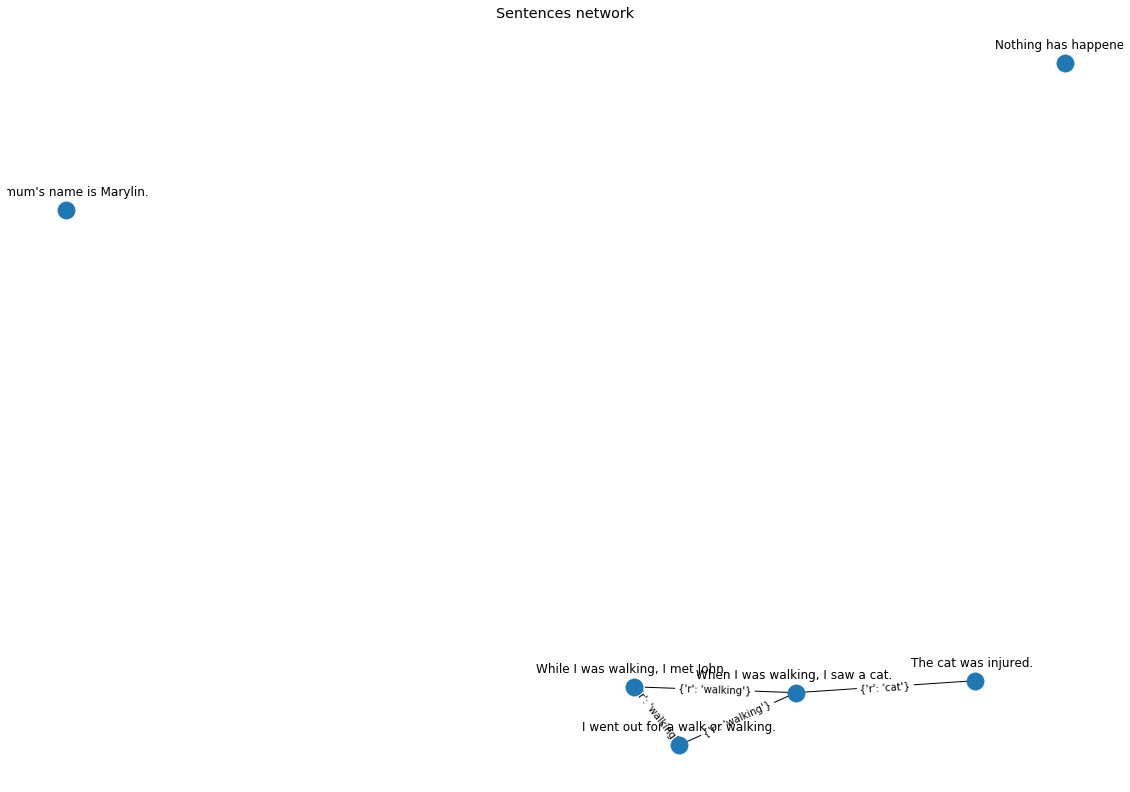

In [1]:
#StackOverflow example
#
plt.style.use("ggplot")

sentences = [
    "I went out for a walk or walking.",
    "When I was walking, I saw a cat. ",
    "The cat was injured. ",
    "My mum's name is Marylin.",
    "While I was walking, I met John. ",
    "Nothing has happened.",
]

G = nx.Graph()
# set of possible good words
good_words = {"went", "walk", "cat", "walking"}

# remove punctuation and keep only good words inside sentences
words = list(
    map(
        lambda x: set(re.sub(r"[^\w\s]", "", x).lower().split()).intersection(
            good_words
        ),
        sentences,
    )
)

# convert sentences to dict for furtehr labeling
sentences = {k: v for k, v in enumerate(sentences)}

# add nodes
for i, sentence in sentences.items():
    G.add_node(i)

# add edges if two nodes have the same word inside
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        for edge_label in words[i].intersection(words[j]):
            G.add_edge(i, j, r=edge_label)

# compute layout coords
coord = nx.spring_layout(G)

plt.figure(figsize=(20, 14))

# set label coords a bit upper the nodes
node_label_coords = {}
for node, coords in coord.items():
    node_label_coords[node] = (coords[0], coords[1] + 0.04)

# draw the network
nodes = nx.draw_networkx_nodes(G, pos=coord)
edges = nx.draw_networkx_edges(G, pos=coord)
edge_labels = nx.draw_networkx_edge_labels(G, pos=coord)
node_labels = nx.draw_networkx_labels(G, pos=node_label_coords, labels=sentences)
plt.title("Sentences network")
plt.axis("off")

(-1.0808022567890792,
 0.5261255387780308,
 -0.28005732004288864,
 0.7408410738823773)

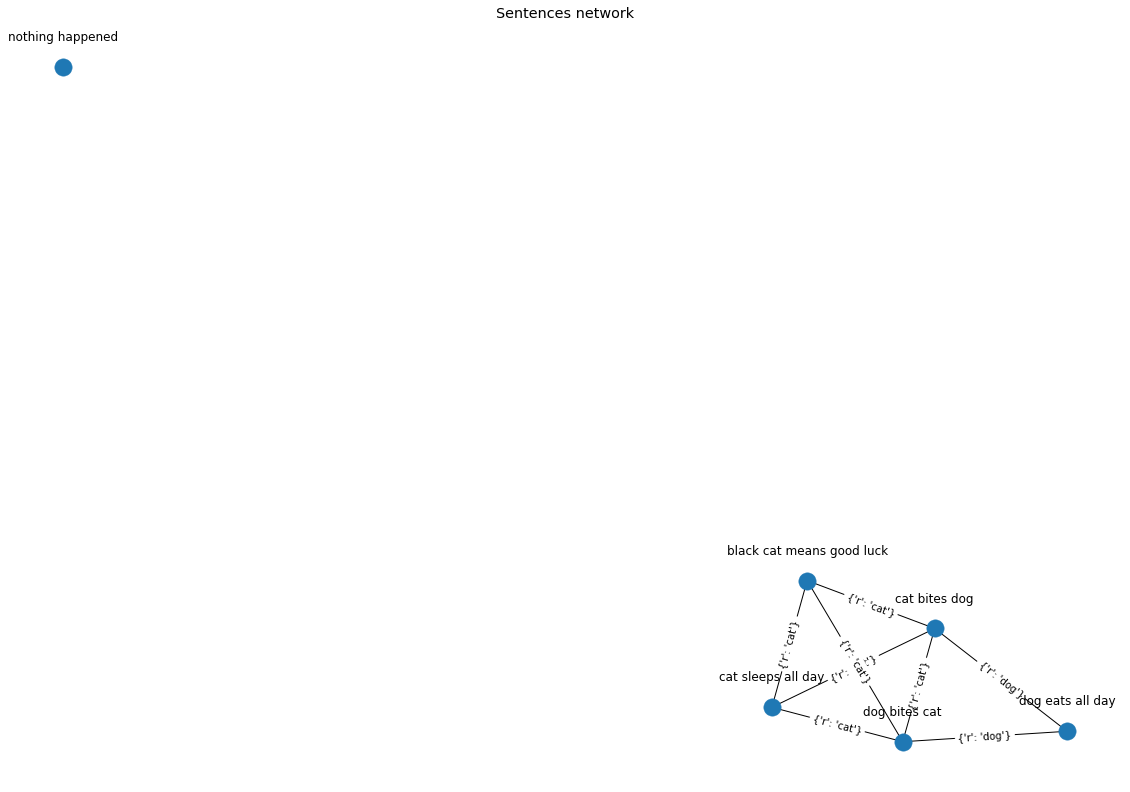

In [9]:
#my
sentences = [
    "cat bites dog",
    "dog bites cat",
    "black cat means good luck",
    "cat sleeps all day",
    "dog eats all day",
    "nothing happened",
]

G = nx.Graph()
# set of possible good words
good_words = {"dog", "cat"}

# remove punctuation and keep only good words inside sentences
words = list(
    map(
        lambda x: set(re.sub(r"[^\w\s]", "", x).lower().split()).intersection(
            good_words
        ),
        sentences,
    )
)

# convert sentences to dict for furtehr labeling
sentences = {k: v for k, v in enumerate(sentences)}

# add nodes
for i, sentence in sentences.items():
    G.add_node(i)

# add edges if two nodes have the same word inside
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        for edge_label in words[i].intersection(words[j]):
            G.add_edge(i, j, r=edge_label)

# compute layout coords
coord = nx.spring_layout(G)

plt.figure(figsize=(20, 14))

# set label coords a bit upper the nodes
node_label_coords = {}
for node, coords in coord.items():
    node_label_coords[node] = (coords[0], coords[1] + 0.04)

# draw the network
nodes = nx.draw_networkx_nodes(G, pos=coord)
edges = nx.draw_networkx_edges(G, pos=coord)
edge_labels = nx.draw_networkx_edge_labels(G, pos=coord)
node_labels = nx.draw_networkx_labels(G, pos=node_label_coords, labels=sentences)
plt.title("Sentences network")
plt.axis("off")

#### Update
If you want to measure the similarity between different sentences, you may want to calculate the difference between sentence embedding.
This gives you an opportunity to find semantic similarity between sentences with different words like "A soccer game with multiple males playing" and "Some men are playing a sport". Almost SoTA approach using BERT can be found at https://keras.io/examples/nlp/semantic_similarity_with_bert/, more simple approaches https://stackoverflow.com/questions/45869881/finding-similarity-between-2-sentences-using-word2vec-of-sentence-with-python.
Since you have similarity measure, just replace add_edge block to add new edge only if similarity measure is greater than some threshold. Resulting add edges code will look like this:

#### add edges if two nodes have the same word inside
tresold = 0.90  
for i in range(len(words)):  
    for j in range(i + 1, len(words)):  
        # suppose you have some similarity function using BERT or PCA  
        similarity = check_similarity(sentences[i], sentences[j])  
        if similarity > tresold:  
            G.add_edge(i, j, r=similarity)  

## 2. Create Vocab with CountVectorizer
Tokenize, remove the stop words and create the vocabulary. Then draw the graph based on this vocabulary. I am showing below and example on unigram based tokens but much better approach will be to identify phrases (ngrams) and use them as vocabulary instead of unigrams. Sentence similarly will be pictorially depicted by nodes (and the corresponding sentences) having more in and degree.

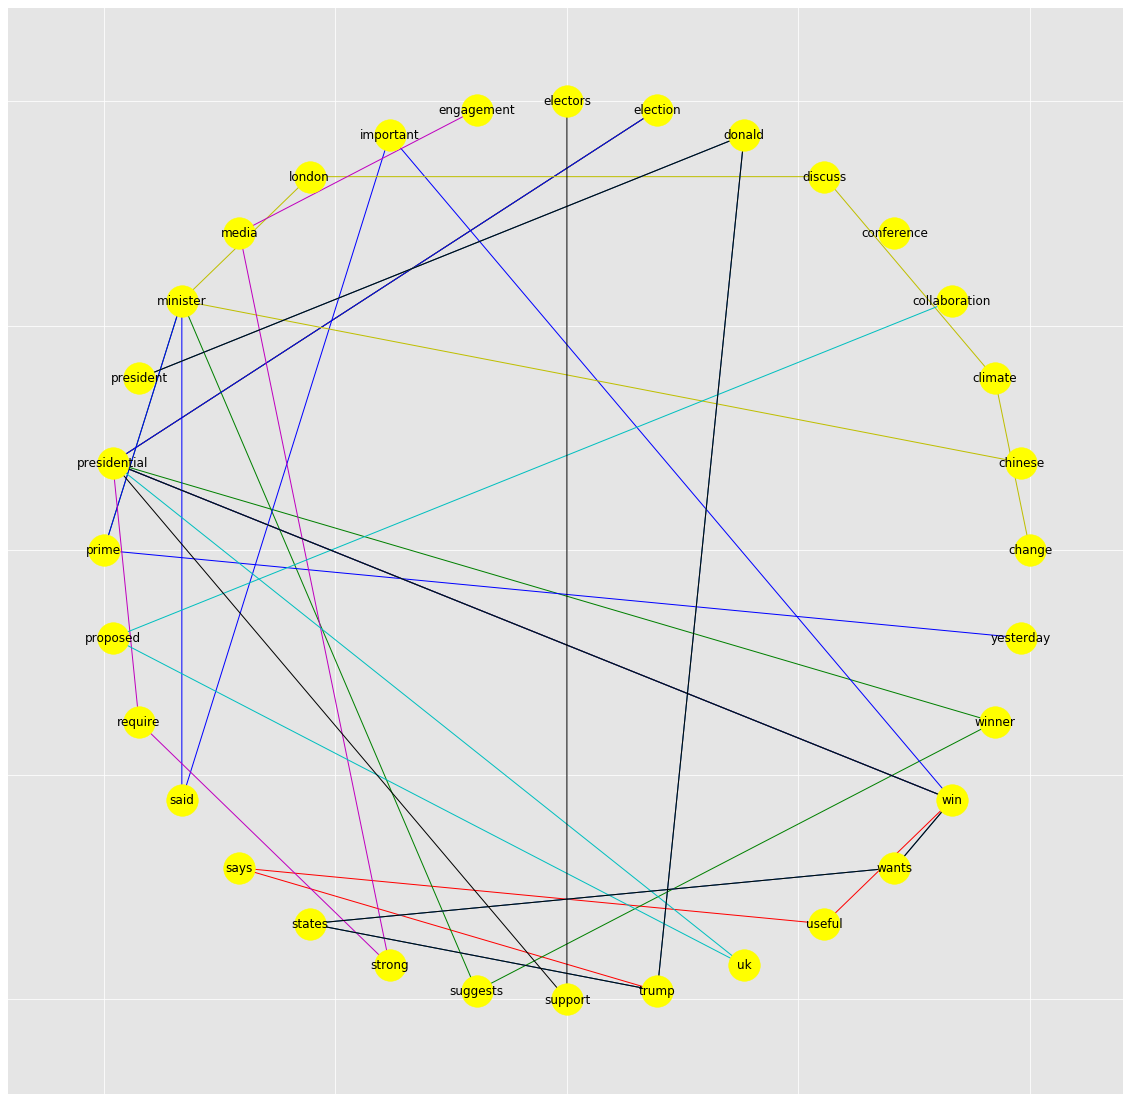

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
  "Trump says that it is useful to win the next presidential election",
  "The Prime Minister suggests the name of the winner of the next presidential election",
  "In yesterday conference, the Prime Minister said that it is very important to win the next presidential election",
  "The Chinese Minister is in London to discuss about climate change",
  "The president Donald Trump states that he wants to win the presidential election. This will require a strong media engagement",
  "The president Donald Trump states that he wants to win the presidential election. The UK has proposed collaboration",
  "The president Donald Trump states that he wants to win the presidential election. He has the support of his electors",
]

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), stop_words="english")
vectorizer.fit_transform(corpus)


G = nx.DiGraph()
G.add_nodes_from(vectorizer.get_feature_names())

all_edges = []
for s in corpus:
  edges = []
  previous = None
  for w in s.split():
    w = w.lower()
    if w in vectorizer.get_feature_names():
      if previous:
        edges.append((previous, w))
        #print (previous, w)
      previous = w   

  all_edges.append(edges)


plt.figure(figsize=(20,20))
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='yellow', node_size = 1000)
nx.draw_networkx_labels(G, pos)
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k']
for i, edges in enumerate(all_edges):
  nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[i], arrows=True)
#nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()

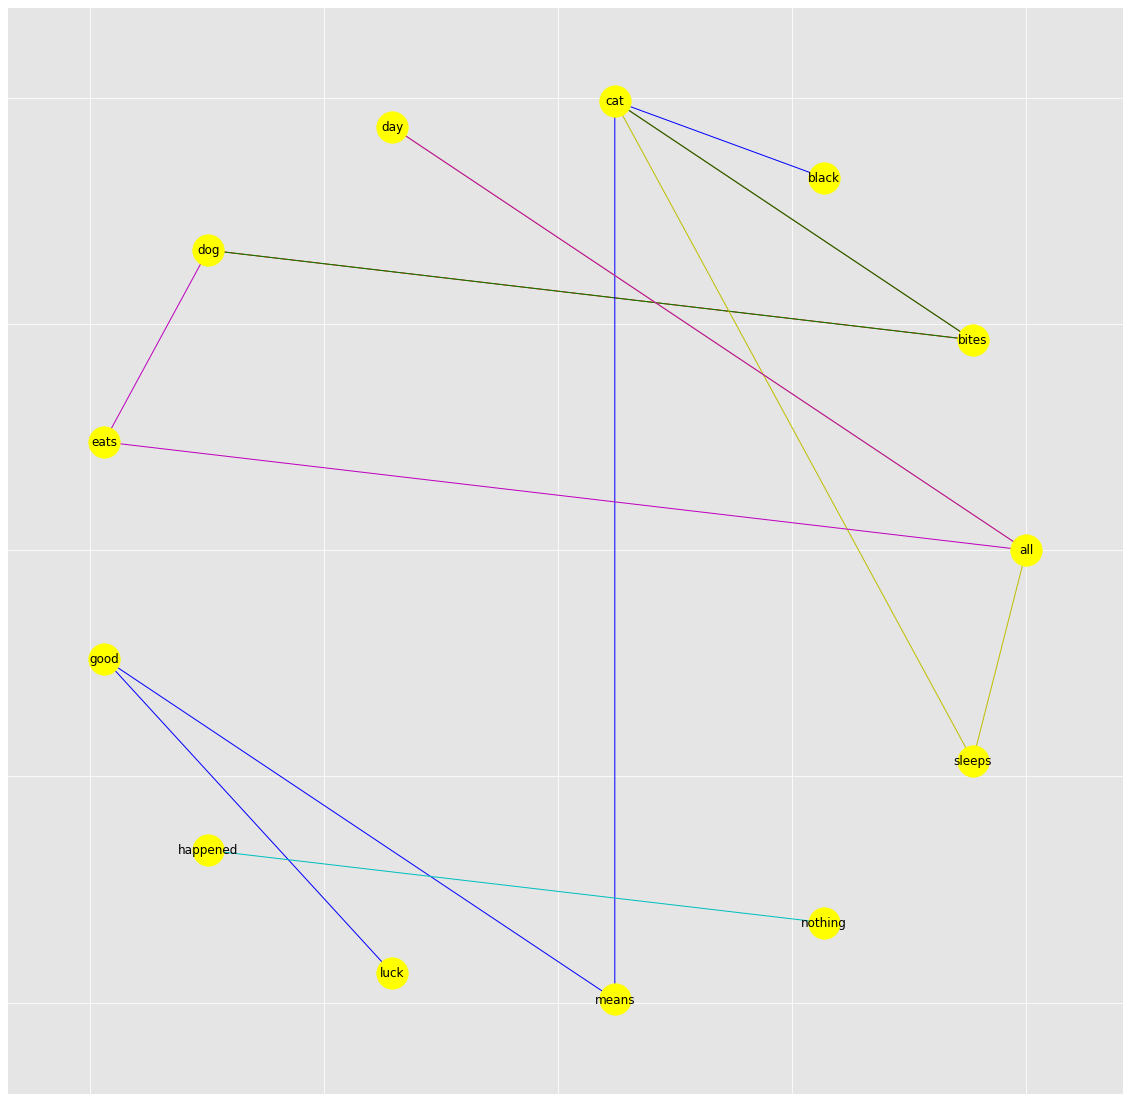

In [23]:
#my
corpus = [
  "cat bites dog",
    "dog bites cat",
    "black cat means good luck",
    "cat sleeps all day",
    "dog eats all day",
    "nothing happened"
]

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1)) #, stop_words="english"
vectorizer.fit_transform(corpus)


G = nx.DiGraph()
G.add_nodes_from(vectorizer.get_feature_names())

all_edges = []
for s in corpus:
  edges = []
  previous = None
  for w in s.split():
    w = w.lower()
    if w in vectorizer.get_feature_names():
      if previous:
        edges.append((previous, w))
        #print (previous, w)
      previous = w   

  all_edges.append(edges)


plt.figure(figsize=(20,20))
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='yellow', node_size = 1000)
nx.draw_networkx_labels(G, pos)
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k']
for i, edges in enumerate(all_edges):
  nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[i], arrows=True)
#nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()